## Assignment
### Harsha kankanamge
Repeat this analysis for Feb 1 - 15, 2018.       

1. Were there a lot more 311 calls for service during this time period in 2018?          

2. Was the distribution of calls by neighborhood similar to the one shown above?          

In [1]:
# import libraries

# to read from a Socrata open dataset
import sodapy 
from sodapy import Socrata

# to manipulate data
import pandas as pd
import geopandas as gpd
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
# draw maps in the notebook
#%matplotlib inline 

In [2]:
socrata_domain = "data.buffalony.gov"
socrata_dataset_identifier = "drz9-ujg7"
#app_token = ..... not necessary but helps with app development

client = Socrata(socrata_domain, None) # put app_token where None is if you get an app token
metadata = client.get_metadata(socrata_dataset_identifier)
metadata.keys() # metadat is a dictionary - these are the keys. just for demonstration purposes

dict_keys(['id', 'name', 'averageRating', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'indexUpdatedAt', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'columns', 'grants', 'owner', 'query', 'rights', 'tableAuthor', 'flags'])

In [3]:
#you can access specific information in the metadata

[x['fieldName'] for x in metadata['columns']]# show field names in dataset

['the_geom',
 'shape_starea',
 'shape_stlength',
 'objectid',
 'nbhdname',
 'placename',
 'objectid_1',
 'nbhdnum',
 'calcacres',
 'sqmiles',
 'shape_leng',
 'sde_vector_gis_osp_neighborhoods_2018_area']

In [4]:
meta_nbhd = [x for x in metadata['columns'] if x['fieldName'] == 'nbhdname'][0]
meta_nbhd

{'id': 363400942,
 'name': 'NbhdName',
 'dataTypeName': 'text',
 'fieldName': 'nbhdname',
 'position': 14,
 'renderTypeName': 'text',
 'tableColumnId': 66025892,
 'cachedContents': {'largest': 'West Side',
  'null': '0',
  'top': [{'item': 'Allentown', 'count': '1'},
   {'item': 'Seneca Babcock', 'count': '1'},
   {'item': 'Lovejoy', 'count': '1'},
   {'item': 'Fruit Belt', 'count': '1'},
   {'item': 'Delavan Grider', 'count': '1'},
   {'item': 'Kensington-Bailey', 'count': '1'},
   {'item': 'Genesee-Moselle', 'count': '1'},
   {'item': 'Grant-Amherst', 'count': '1'},
   {'item': 'Ellicott', 'count': '1'},
   {'item': 'Central', 'count': '1'},
   {'item': 'West Side', 'count': '1'},
   {'item': 'Black Rock', 'count': '1'},
   {'item': 'Lower West Side', 'count': '1'},
   {'item': 'Fillmore-Leroy', 'count': '1'},
   {'item': 'Kaisertown', 'count': '1'},
   {'item': 'Broadway Fillmore', 'count': '1'},
   {'item': 'Riverside', 'count': '1'},
   {'item': 'Central Park', 'count': '1'},
   {

In [5]:
url = "https://data.buffalony.gov/resource/drz9-ujg7.geojson"
gdf = gpd.read_file(url)

In [6]:
gdf.crs

{'init': 'epsg:4326'}

In [7]:
gdf.shape[0]

35

In [8]:
gdf.geometry.name

'geometry'

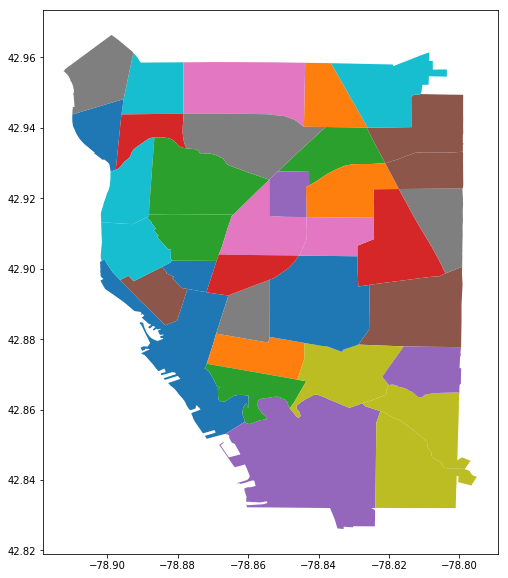

In [9]:
gdf.plot(column='nbhdname', figsize=(9,10));

## Reproject to EPSG 3857

Web Mercator Auxiliary Sphere, WGS 84, units = meters

Create a new dataframe with a field containing sq. kilometers.   

The data owner provided a field with sq. miles and acres calculated. We could use either (or both) of these for a choropleth map. But, since the new units of the projected data are meters, we can calculate sq. kilometers as a third measure of size for a choropleth map.

In [10]:
neighborhoods = gdf[['nbhdname', 'geometry', 'sqmiles','calcacres']].copy() # make sure you copy to avoid warnings later
neighborhoods = neighborhoods.to_crs({'init': 'epsg:3857'})
neighborhoods['sqkilo']=neighborhoods.geometry.area/1000**2 # in sq kilometers
neighborhoods['sqkilo'][:10]

0     7.147233
1     1.610757
2     4.106326
3    11.110428
4     4.101096
5     4.350064
6     4.942666
7     8.721404
8     2.933698
9    19.980053
Name: sqkilo, dtype: float64

### Get open data on pot hole service requests
The City of Buffalo has an open data set on 311 service calls. One type of call they receive from the public is for pot hole repair. On Feb 16, WIVB reported on the city's pot hole blitz (https://www.wivb.com/news/local-news/city-of-buffalo-goes-on-saturday-pothole-blitz/1788423791). The story indicted where the crews were dispatched to fix the pot holes.

The blitz included:

* crews on Main Street between Humboldt and Hertel
* crew on South Park Avenue between Bailey and Dorrance
* crew the Hamlin Park neighborhood
* crew the Broadway Fillmore area
* other crews across the city on various pothole requests that were logged into 311.

**The story went on to indicate:**       
"The City of Buffalo said that 311 calls are not as high as they were in 2018. In February 2018, the city got 1100 calls for potholes through 311. In the two weeks of February 2019, the city said there have been 400 calls."

We will pull data for the first two weeks in Feb 2018 and map that data to the Buffalo Neighborhoods.    

The SODA endpoint is:
  
311 Service Requests https://data.buffalony.gov/resource/p7e8-krif.geojson

Read this into a geodataframe since there is a geometry in the dataset.

The query will include an SQL query to

increase the default limit of 1000 records (\?$limit=1000000\&)     

Select specific dates:                            

     * open_date between 2/1/2018 and 2/15/2018 ($where=open_date between '2018-02-01T00:00:00' and '2018-02-15T00:00:00')

Select specific call type: type contains 'Pot Hole' (and type like 'Pot Hole%')  

The statement below uses URL percent encoding to represent all ascii charaters.
* %20 is a space
* %25 is a percent sign - used to ignore whatever characters follow the words Pot Hole
* %27 is a single quotation mark

In [11]:
url='https://data.buffalony.gov/resource/p7e8-krif.geojson?$limit=1000000&\
$where=open_date%20between%20%272018-02-01T00:00:00%27%20and%20%272018-02-15T00:00:00%27\
%20and%20type%20like%20%27Pot%20Hole%25%27'

phgdf =  gpd.read_file(url)
phgdf.crs

{'init': 'epsg:4326'}

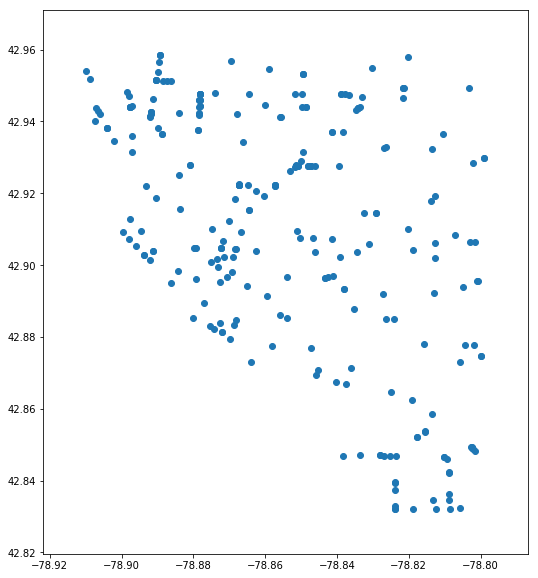

In [12]:
nrows = phgdf.shape[0] # how many rows in this slice of the data
phgdf.plot(figsize=(9,10));

### Spatial Join
to count the number of pothole service requests in each neighborhood. Before two spatial datasets are joined they have to be in the same projection. However, if you enter
* phgdf = phgdf.to_crs({'init': 'epsg:3857'})

in the next cell you will get an error about geometry type being NONE instead of POINT. So first we must
* remove records with no location information
* reproject to same crs as neighborhoods

In [13]:
phgdf['Type'] = phgdf.geom_type

In [14]:
phgdf['Type']=phgdf['Type'].astype(str)
phgdf = phgdf[phgdf.Type != 'None'] # keep only point types
removed = nrows -phgdf.shape[0] # how many rows are miising coordinate information
pctremoved=(removed/nrows)*100 # what percent of the data is missing spatial information
print("Original number of rows = {}\nNumber of rows missing coordinates = {},\nPercent missing data ={:6.1f}%".format(nrows,removed, pctremoved))

Original number of rows = 334
Number of rows missing coordinates = 57,
Percent missing data =  17.1%


In [15]:
phgdf = phgdf.to_crs({'init': 'epsg:3857'})

So, there are 271 valid requests for pot hole repairs in the first week of Feb, 2018. 

Use sjoin method to join the pot hole request points to the neighborhood polygons. Both of these datasets have a geometry field which is used in a spatial join.

* How = inner: "use intersection of keys from both dfs, retain only left_df geometry column", and 
* op = within (can be intersects, contains, or within).

In [16]:
PH_in_neigh = gpd.sjoin(phgdf,neighborhoods,how='inner',op='within')
PH_in_neigh.shape

(271, 36)

### One call not joined to a neighborhood

This means the point does not fall within any of the polygons.

### Summarize the number of calls for each neighborhood
* group the point data (from the spatial join) by the neighborhood name
* count the number of points in each group.

In [17]:
rfs =PH_in_neigh.nbhdname.groupby(PH_in_neigh['nbhdname'])\
            .count()\
            .sort_values(ascending=False)
rfsph = rfs.to_frame(name='counts').reset_index()
rfsph.shape

(34, 2)

### Join final counts in each neighborhood to the polygon database
This is a regular merge - not a spatial join. The dataframe with the final counts is not geospatial, so the neighborhood names (in nbhdname) are used for the merge.   

**However** there are 35 neighborhoods (polygons) but one does not have any pot hole service calls assigned to it.

### Proportional symbols
Instead of using a classification scheme and min/max circle size (The ArcGIS approach), an alternative is to create proportional symbols. The size of the symbol is proportional to the value mapped. For example, if value = 100 is circle size 5, then value of 200 is size 10. With this approach only positive values are mapped (no zeros).

Get rid of zeros by merging the dataframes together so that only polygons with positive counts are kept.

In [18]:
nozerodf = pd.merge(neighborhoods,rfsph)
nozerodf.tail()

,nbhdname,geometry,sqmiles,calcacres,sqkilo,counts
29,Hamlin Park,(POLYGON ((-8777608.583221421 5300964.48174737...,0.47307671000000001,302.76909584999999,2.286270,11
30,Fruit Belt,(POLYGON ((-8779976.808981806 5295748.75442217...,0.68012198999999995,435.27807389999998,3.284536,5
31,South Park,(POLYGON ((-8773788.155840665 5290166.51688690...,1.6651265500000001,1065.6809914999999,8.026896,17
32,Kaisertown,(POLYGON ((-8771922.533265801 5293379.36050432...,0.88003118999999996,563.21996217000003,4.246151,4
33,MLK Park,(POLYGON ((-8777063.884218687 5297327.90975671...,0.68687759000000004,439.60165978999999,3.318255,5


### Calculate circle size for each point
Use the minimum value in the data and the smallest circle size to determine circle size for all points

In [19]:
minct = nozerodf['counts'].min()
mincir = 5
nozerodf['ssize'] = nozerodf['counts']/minct * mincir
nozerodf['ssize'] =nozerodf['ssize'].round(0).astype(int)
nozerodf['ssize'][:10]

0    20
1    35
2    55
3    40
4    70
5    40
6     5
7    35
8    75
9    50
Name: ssize, dtype: int32

### Map counts as graduated circles using a classification scheme

Counts and amounts are mapped as graduated circles. The center of the circle is the centroid of each neighborhood polygon. The classification scheme allows for creating a legend.

* Use the centroid method to determine the geometric center of neighborhood.
* Set this field to the geometry field.

In [20]:
nozerodf['centroids']=nozerodf['geometry'].centroid
nozerodf = nozerodf.set_geometry('centroids')

### Classify values to be mapped
Traditionally, values to be mapped are divided into a fixed number of groups. The analyst determines the number of groups and the method used to group the data. There are links on Blackboard to information related to this topic. PYSAL's mapclassify method offers a variety of ways to group data. Detailed information of the methods supported is at https://pysal.readthedocs.io/en/v1.6/library/esda/mapclassify.html

There are also three methods to evaluate how well the classification scheme works for the data. Before we test a few schemes we will get a bit of information about the values in our dataset.

In [21]:
maxc = nozerodf['counts'].max()
minc = nozerodf['counts'].min()
rangec = maxc-minc
print ("Min calls = {}. Max calls = {}. Range = {}".format(minc,maxc,rangec))

Min calls = 1. Max calls = 24. Range = 23


In [22]:
import mapclassify # from pysal.esda

In [23]:
fj4 =mapclassify.Fisher_Jenks(nozerodf['counts'],k=4) # method = Fisher Jenks, number of classes = 4
fjm1=fj4.get_adcm() #absolute deviation around class median
fjm2=fj4.get_gadf() #goodness of absolute deviation of fit
fjm3=fj4.get_tss() # total sum of squares around class means

print("Fisher Jenks 4 classes\nACDM = {:6.3f}\nGADF = {:6.3f}\nTSS = {:6.3f}".format(fjm1,fjm2,fjm3))

Fisher Jenks 4 classes
ACDM = 37.000
GADF =  0.704
TSS = 66.041


In [24]:
eqi4 =mapclassify.Equal_Interval(nozerodf['counts'],k=4) # method = Equal Interval, number of classes = 4
eqim1=eqi4.get_adcm() #absolute deviation around class median
eqim2=eqi4.get_gadf() #goodness of absolute deviation of fit
eqim3=eqi4.get_tss() # total sum of squares around class means

print("Equal Interval 4 classes\nACDM = {:6.3f}\nGADF = {:6.3f}\nTSS = {:6.3f}".format(eqim1,eqim2,eqim3))

Equal Interval 4 classes
ACDM = 37.000
GADF =  0.704
TSS = 66.041


We could continue to test differrent methods and/or change the number of classes, but........                             
Mapclassify has a method to determine the "best" classification method and number of classes.

In [25]:
ks = mapclassify.K_classifiers(nozerodf['counts'])
ks.best.name

C:\Users\harsh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


'Fisher_Jenks'

In [26]:
ks.best.k  # optimum numer of classes

6

In [27]:
fj6 =mapclassify.Fisher_Jenks(nozerodf['counts'],k=6) # method = Fisher Jenks, number of classes = 6
fjm1=fj6.get_adcm() #absolute deviation around class median
fjm2=fj6.get_gadf() #goodness of absolute deviation of fit
fjm3=fj6.get_tss() # total sum of squares around class means

print("Fisher Jenks 6 classes\nACDM = {:6.3f}\nGADF = {:6.3f}\nTSS = {:6.3f}".format(fjm1,fjm2,fjm3))

Fisher Jenks 6 classes
ACDM = 19.000
GADF =  0.848
TSS = 18.133


In [28]:
print ("Bin assignments are in fj6.yb and class cutpoints are in fj6.bins.")
print ("The bin cutpoints are {}".format(fj6.bins))

Bin assignments are in fj6.yb and class cutpoints are in fj6.bins.
The bin cutpoints are [ 3  5  8 11 17 24]


### Create field to assign circle size

We will use the classification results to assign values to a new field in the dataframe that indicates the size of the circle to draw.

We will add a new field that indicates the cutpoint (upper class) value for the class into which the point falls.

For a simplified legend (Bokeh doesn't have a graduated circle legend) we will assign colors to each point based on the bin.

In [29]:
nozerodf['bins'] = fj6.yb
cutpoints =fj6.bins
cutpoints

array([ 3,  5,  8, 11, 17, 24], dtype=int64)

In [30]:
def cutpoint_value(row):
    return cutpoints[row['bins']]

In [31]:
nozerodf['lsize'] =nozerodf.apply (lambda row: cutpoint_value (row),axis=1) 
nozerodf.head(10)

,nbhdname,geometry,sqmiles,calcacres,sqkilo,counts,ssize,centroids,bins,lsize
0,Genesee-Moselle,(POLYGON ((-8772416.996419497 5296559.07454772...,1.47959668,946.94187391000003,7.147233,4,20,POINT (-8773994.185873291 5297794.935210697),1,5
1,Allentown,(POLYGON ((-8779653.692074601 5297097.05578435...,0.33354297999999999,213.46750796000001,1.610757,7,35,POINT (-8780446.359534284 5296543.288019243),2,8
2,West Hertel,(POLYGON ((-8780700.712571777 5305677.54742905...,0.84885460000000001,543.26694092000002,4.106326,11,55,POINT (-8781624.309603618 5304544.537125081),3,11
3,Central,(POLYGON ((-8783340.355813986 5297073.00487966...,2.3023353599999998,1473.49462724,11.110428,8,40,POINT (-8780575.657097308 5293112.515570052),2,8
4,Elmwood Bryant,(POLYGON ((-8779794.565021925 5299104.69078922...,0.84892204000000004,543.31010802000003,4.101096,14,70,POINT (-8780433.715698674 5298216.715782064),4,17
5,Fillmore-Leroy,(POLYGON ((-8775844.626891373 5301069.18769751...,0.89977421000000002,575.85549312000001,4.350064,8,40,POINT (-8775916.274480719 5301790.813848895),2,8
6,Delavan Grider,(POLYGON ((-8776808.903445955 5298992.59193480...,1.0227150199999999,654.53761255999996,4.942666,1,5,POINT (-8775489.570209272 5300097.942009616),0,3
7,Lovejoy,(POLYGON ((-8771895.127383217 5296570.98019066...,1.80658257,1156.21284599,8.721404,7,35,POINT (-8773322.145359097 5294876.822697167),2,8
8,Black Rock,(POLYGON ((-8782663.178737236 5303422.25013478...,0.60669930999999999,388.28755895,2.933698,15,75,POINT (-8783311.200631212 5302734.9392576),4,17
9,Hopkins-Tifft,(POLYGON ((-8779366.576895932 5289643.06054361...,4.1442699799999998,2652.3327890400001,19.980053,10,50,POINT (-8776646.487858228 5288586.174991202),3,11


In [32]:
def label_color(row):
    return fillcolors[row['bins']]

In [33]:
fillcolors = ['#daf7a6','#ffc300','#ff5733','#c70039','#900c3f','#581845']
nozerodf['ptcolor']=nozerodf.apply (lambda row: label_color (row),axis=1) 

### Use BOKEH to create interactive maps with graduated circles.

In [34]:
from bokeh.tile_providers import STAMEN_TERRAIN, CARTODBPOSITRON_RETINA
from bokeh.io import output_notebook, show, output_file, save
from bokeh.plotting import figure
from bokeh.models import (ColumnDataSource,HoverTool,LogColorMapper)

output_notebook()

Loading BokehJS ...

In [35]:
def getmyPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

In [36]:
geom =nozerodf.geometry.name
geom

'centroids'

In [37]:
nozerodf['x'] = nozerodf.apply(getmyPointCoords, geom=geom, coord_type='x', axis=1)
nozerodf['y'] = nozerodf.apply(getmyPointCoords, geom=geom, coord_type='y', axis=1)

In [38]:
nozerodf = nozerodf.sort_values('lsize')

In [46]:
# simple static plot

f = figure(plot_height=700, plot_width=800, title="Total Pot Hole Calls for Service")
f.add_tile(STAMEN_TERRAIN)

f.background_fill_color = 'gray'

nozerodf1 = nozerodf.drop(['geometry','centroids'], axis=1).copy()

fsource = ColumnDataSource(nozerodf1)

f.circle('x', 'y', source = fsource, alpha=0.6, size='ssize', fill_color = 'ptcolor',line_color = 'ptcolor',legend='lsize')
show(f)

In [40]:
# interactive plot with pop-ups

TOOLS="pan,wheel_zoom,box_zoom,reset,save"

f = figure(title="Feb 2018 311 calls for pot hole service", tools=TOOLS,
           plot_width=800, plot_height=700,
           outline_line_color=None,
           min_border=0, min_border_left=0, min_border_right=0,
           min_border_top=0, min_border_bottom=0)
f.grid.grid_line_color = None
f.add_tile(CARTODBPOSITRON_RETINA)
f.background_fill_color = 'gray'

incsource = ColumnDataSource(dict(
    xpt = nozerodf['x'],
    ypt= nozerodf['y'],
    cnt= nozerodf['counts'],
    nname = nozerodf['nbhdname'],
    circlesize=nozerodf['ssize'],
    colors = nozerodf['ptcolor'],
    legsize = nozerodf['lsize']
    ))
                           
f.title.text_font_style = "italic"
f.title.text_font_size = '14pt'

Circle=f.circle( x='xpt', y='ypt', size='circlesize', color='colors',legend = 'legsize',source=incsource)

c_hover = HoverTool(renderers=[Circle])
c_hover.point_policy = "follow_mouse"
c_hover.tooltips=[
    ("Neighborhood", "@nname"),
    ("Number of calls", "@cnt")    
]

f.add_tools(c_hover)
                            
output_file("Feb2019PotHoles_PC.html", title="Feb 2018 311 calls for pot hole service")
show(f)

## Make Static Chorpleth Map

In [41]:
nozerodf = nozerodf.set_geometry('geometry')

In [42]:
nozerodf['mapvaluesqmi']=nozerodf['counts']/nozerodf['sqmiles'].astype(float)
nozerodf['mapvalueacre']=nozerodf['counts']/nozerodf['calcacres'].astype(float)
nozerodf['mapvaluesqki']=nozerodf['counts']/nozerodf['sqkilo'].astype(float)

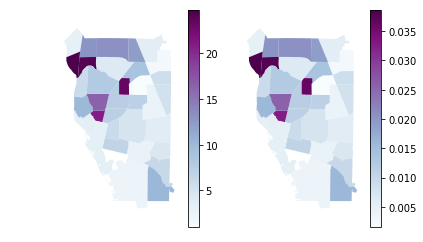

In [43]:
fig, axes = plt.subplots(ncols=2)

m1 =nozerodf.plot(column='mapvaluesqmi',cmap = 'BuPu',legend= True,ax=axes[0]);
m2=nozerodf.plot(column='mapvalueacre',cmap = 'BuPu',legend= True,ax=axes[1]);
m1.axis('off');
m2.axis('off');

Text(0.5, 1.0, 'Calls per Sq. Kilometer')

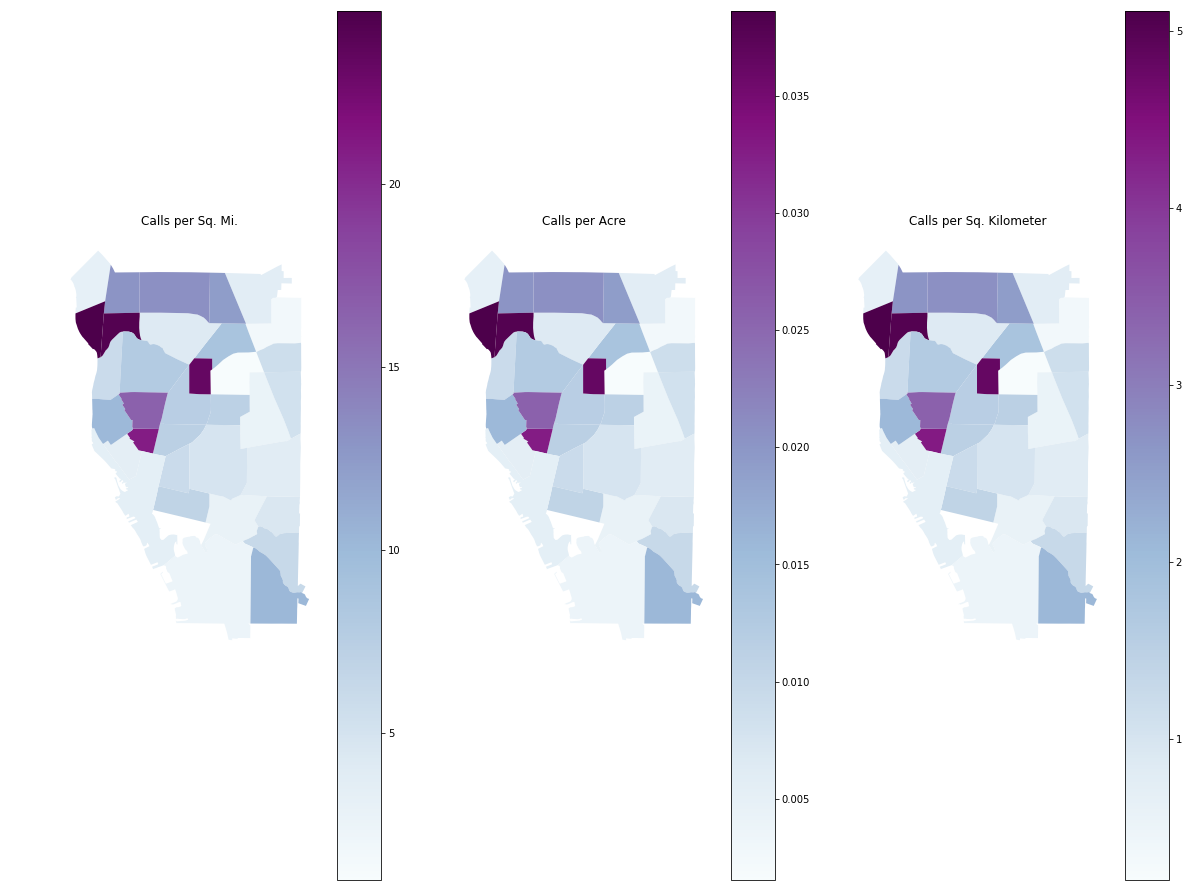

In [44]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 16))
ax1 = nozerodf.plot(ax=ax1, column='mapvaluesqmi', cmap = 'BuPu',legend=True)
ax2 = nozerodf.plot(ax=ax2, column='mapvalueacre', cmap = 'BuPu',legend=True)
ax3 = nozerodf.plot(ax=ax3, column='mapvaluesqki', cmap = 'BuPu',legend=True)
ax1.axis('off')
ax1.set_title('Calls per Sq. Mi.')
ax2.axis('off')
ax2.set_title('Calls per Acre')
ax3.axis('off')
ax3.set_title('Calls per Sq. Kilometer')

##### There are 271 valid requests for pot hole repairs in the first weeks of Feb, 2018. and there are 296 valid requests for pot hole repairs in the first weeks of Feb, 2019 . so there is no that much different. News story is not true
##### Distribution of calls by neighborhood in 2018 somewhat similar to the 2019 in this period of time

### Count calls in each neighborhood

In [45]:
rfs =PH_in_neigh.nbhdname.groupby(PH_in_neigh['nbhdname'])\
            .count()\
            .sort_values(ascending=False)
rfsph = rfs.to_frame(name='counts').reset_index()

### Calculate circle size

In [46]:
nozerodf = pd.merge(gdf,rfsph)
minct = nozerodf['counts'].min()
mincir = 20
nozerodf['ssize'] = (nozerodf['counts']/minct * mincir)**.5
nozerodf['ssize'] =nozerodf['ssize'].round(0).astype(int)

### Get x,y coordinates for mapping

In [47]:
nozerodf['centroids']=nozerodf['geometry'].centroid
nozerodf = nozerodf.set_geometry('centroids')

In [48]:
def getmyPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

In [49]:
geom =nozerodf.geometry.name
nozerodf['x'] = nozerodf.apply(getmyPointCoords, geom=geom, coord_type='x', axis=1)
nozerodf['y'] = nozerodf.apply(getmyPointCoords, geom=geom, coord_type='y', axis=1)


In [50]:
nozerodf.head()

,nbhdname,sqmiles,objectid_1,objectid,shape_leng,placename,sde_vector_gis_osp_neighborhoods_2018_area,calcacres,shape_stlength,nbhdnum,shape_starea,geometry,counts,ssize,centroids,x,y
0,Genesee-Moselle,1.47959668,31,23,28981.7250981,Buffalo,41248623.032700002,946.94187391000003,28981.725319542264,23,41248622.208818763,"(POLYGON ((-78.803962665535 42.898656777428, -...",4,9,POINT (-78.81813076696949 42.90678783292247),-78.818131,42.906788
1,Allentown,0.33354297999999999,24,3,12763.1189798,Buffalo,9298607.4520699997,213.46750796000001,12763.118890667369,3,9298607.124521479,"(POLYGON ((-78.86897100867 42.902196962558, -7...",7,12,POINT (-78.87609164151722 42.8985527620775),-78.876092,42.898553
2,West Hertel,0.84885460000000001,1,11,20858.132954100001,Buffalo,23664613.287999999,543.26694092000002,20858.132570415859,11,23664613.529301703,"(POLYGON ((-78.878376553824 42.958633404865, -...",11,15,POINT (-78.88667336709899 42.95118375922944),-78.886673,42.951184
3,Central,2.3023353599999998,26,1,78080.953510899999,Buffalo,64185169.220899999,1473.49462724,78080.952053290006,1,64185169.866503179,"(POLYGON ((-78.90208887251499 42.902038699938,...",8,13,POINT (-78.87725208777054 42.87596820967948),-78.877252,42.875968
4,Elmwood Bryant,0.84892204000000004,22,5,20649.218719699998,Buffalo,23666493.638999999,543.31010802000003,20649.2190189844,5,23666494.19880639,"(POLYGON ((-78.870236491887 42.915406408528, -...",14,17,POINT (-78.87597804770475 42.90956389529074),-78.875978,42.909564


## Make graduated circle map

In [51]:
import folium
def plot_counts(mydf,mygdf):
    # generate a new map
    folium_map = folium.Map(location=[42.9, -78.88],
                            zoom_start=12,
                            tiles="cartodbpositron",
                            width='75%')
    #style_function = dict(color=#e6e6e6,weight=2,opacity=0.6)
    folium.Choropleth(
        geo_data=mygdf,
        fill_color='#e6e6e6',
        name='Neighborhoods').add_to(folium_map)

    # for each row in the data, add a cicle marker
    for index, row in mydf.iterrows():
                
        # generate the popup message that is shown on click.
        popup_text = "<b>{}</b><p><i>Total 311 service calls:</i> {}</p> "
        popup_text = popup_text.format(row["nbhdname"],
                          row["counts"])
                          
        
        # radius of circles
        radius = row['ssize']
        
        # choose the color of the marker
        color="#0A8A9F" # teal
        
        # add marker to the map
        folium.CircleMarker(location=(row["y"],
                                      row["x"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    folium.LayerControl().add_to(folium_map)
    
    return folium_map

In [52]:
plot_counts(nozerodf,gdf)

In [56]:
nozerodf = nozerodf.set_geometry('geometry')
nozerodf['rates']=nozerodf['counts']/nozerodf['sqmiles'].astype(float)


In [57]:
import mapclassify as mc

In [58]:
ks = mc.K_classifiers(nozerodf['rates'])
ks.best.name, ks.best.k

C:\Users\harsh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


('Fisher_Jenks', 5)

In [59]:
classification = mc.Fisher_Jenks(nozerodf['rates'],k=5)
cbins = list(classification.bins)
cbins.insert(0,0)
cbins

[0,
 4.545293445792529,
 7.486487101339533,
 10.209434231890663,
 16.491502564829155,
 24.723944386882525]

In [60]:
def plot_density(mydf,mygdf,mybins):
    
    # generate a new map
    folium_map = folium.Map(location=[42.9, -78.88],
                            zoom_start=12,
                            tiles="OpenStreetMap",
                            width='100%')
    
    folium.Choropleth(
        geo_data=mygdf,
        name = 'Neighborhoods',
        data=mydf,
        columns = ['nbhdname','rates'],
        key_on='feature.properties.nbhdname',
        bins = mybins,
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2).add_to(folium_map)
    
    for index, row in mydf.iterrows():
                
        # generate the popup message that is shown on click.
        popup_text = "<b>{}</b><p><i> Total 311 service calls:</i> {}</p><p><i> Service calls per sq. mi:</i> {:4.1f}</p> "
        popup_text = popup_text.format(row["nbhdname"],
                                       row["counts"],
                                       row['rates'])
                          
        # radius of circles
        radius = 3
        
        # choose the color of the marker
        color="#2a2b2d" # dark gray
        
        # add marker to the map
        folium.CircleMarker(location=(row["y"],
                                      row["x"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)

    folium.LayerControl().add_to(folium_map)
    folium.LatLngPopup().add_to(folium_map)
    return folium_map

In [61]:
plot_density(nozerodf,gdf,cbins)